# ESG Score Prediction with TabTransformer for Energy Sector

This notebook implements a TabTransformer model to predict BESG ESG Score based on various environmental, social, and governance metrics for energy companies.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')

# Import preprocessing utilities
from data_preprocessing import load_and_clean_data, prepare_data_for_modeling

# Import TabTransformer module
from tab_transformer import (
    ESGDataset, TabTransformer, ESGPreprocessor, 
    train_model, evaluate_model, get_feature_importance
)

## 1. Load and Explore the Data

In [ ]:
# Load and preprocess the data
df = load_and_clean_data('../energy_cleaned.csv')

# Display the first few rows
df.head()

Original dataset shape: (1224, 141)
Columns with missing values: 84783
Processed dataset shape: (1224, 141)
Columns with missing values after processing: 1224


,Company,Ticker,Year,BESG ESG Score,BESG Environmental Pillar Score,BESG Social Pillar Score,BESG Governance Pillar Score,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,...,Indep Directors,Raw Materials Used,Percentage Gender Pay Gap Employees Ex Management,Percentage Raw Material from Sustainable Sources,"Revenue, Adj","Net Income, Adj",Margin %,"EPS, Adj",Market Cap ($M),Market Cap Category
0,ACS Actividades de Construccion y Servicios SA,ACS,2014,4.26,3.61,3.31,6.645,50.729,37.511,33.676,...,Yes,55.0,90.09,86.0,NaN,160.5,13.546,0.052,13716.9,Large Cap
1,ACS Actividades de Construccion y Servicios SA,ACS,2015,1.85,0.66,2.38,3.660,55.296,42.616,41.717,...,Yes,55.0,90.09,86.0,NaN,160.5,13.546,0.052,13716.9,Large Cap
2,ACS Actividades de Construccion y Servicios SA,ACS,2016,2.17,1.13,2.37,4.050,55.497,48.354,36.578,...,Yes,55.0,90.09,86.0,NaN,160.5,13.546,0.052,13716.9,Large Cap
3,ACS Actividades de Construccion y Servicios SA,ACS,2017,2.76,1.13,4.30,4.110,57.248,50.317,44.891,...,Yes,55.0,90.09,86.0,NaN,160.5,13.546,0.052,13716.9,Large Cap
4,ACS Actividades de Construccion y Servicios SA,ACS,2018,2.63,1.11,4.20,3.640,62.609,52.280,59.039,...,Yes,55.0,90.09,86.0,NaN,160.5,13.546,0.052,13716.9,Large Cap


In [3]:
# Basic statistics of the target variable
print("Basic statistics of BESG ESG Score:")
df['BESG ESG Score'].describe()

Basic statistics of BESG ESG Score:


count    1224.000000
mean        4.158742
std         1.182408
min         0.600000
25%         3.550000
50%         4.260000
75%         4.790000
max         7.620000
Name: BESG ESG Score, dtype: float64

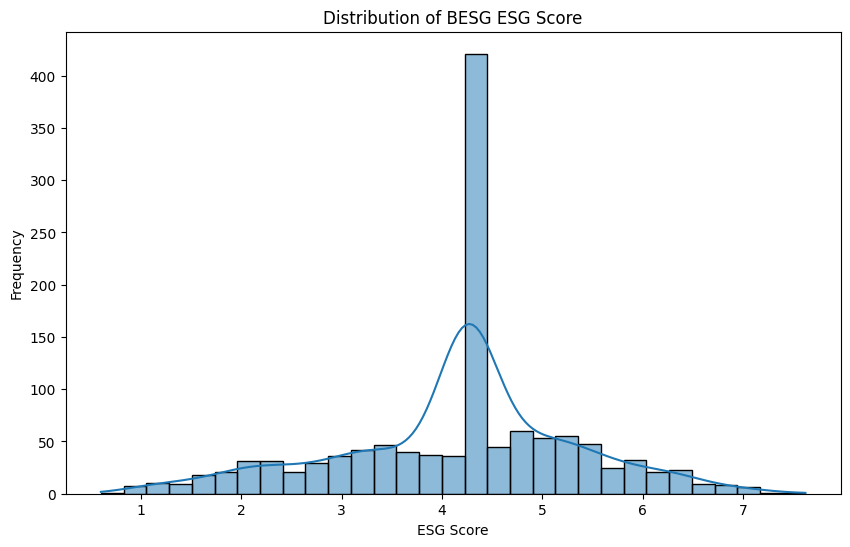

In [4]:
# Distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['BESG ESG Score'], kde=True)
plt.title('Distribution of BESG ESG Score')
plt.xlabel('ESG Score')
plt.ylabel('Frequency')
plt.show()

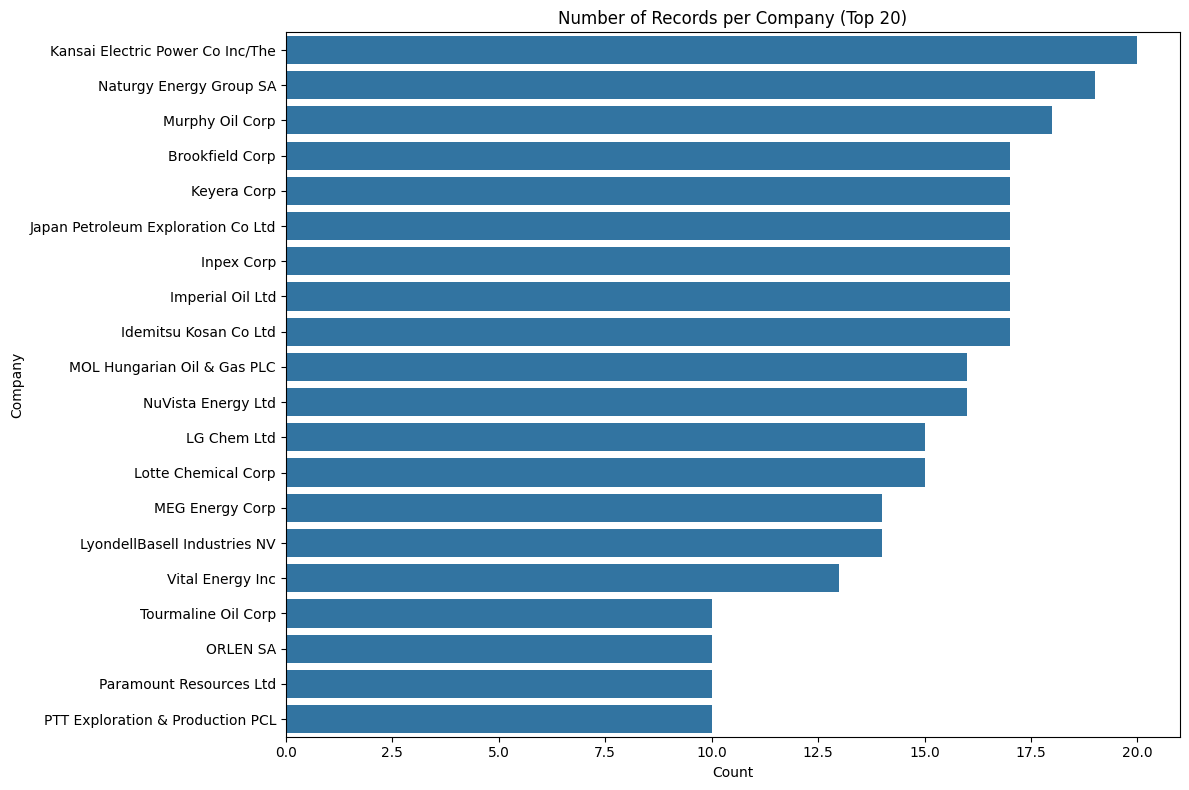

In [5]:
# Examine distribution of companies
plt.figure(figsize=(12, 8))
company_counts = df['Company'].value_counts()[:20]  # Top 20 companies
sns.barplot(x=company_counts.values, y=company_counts.index)
plt.title('Number of Records per Company (Top 20)')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

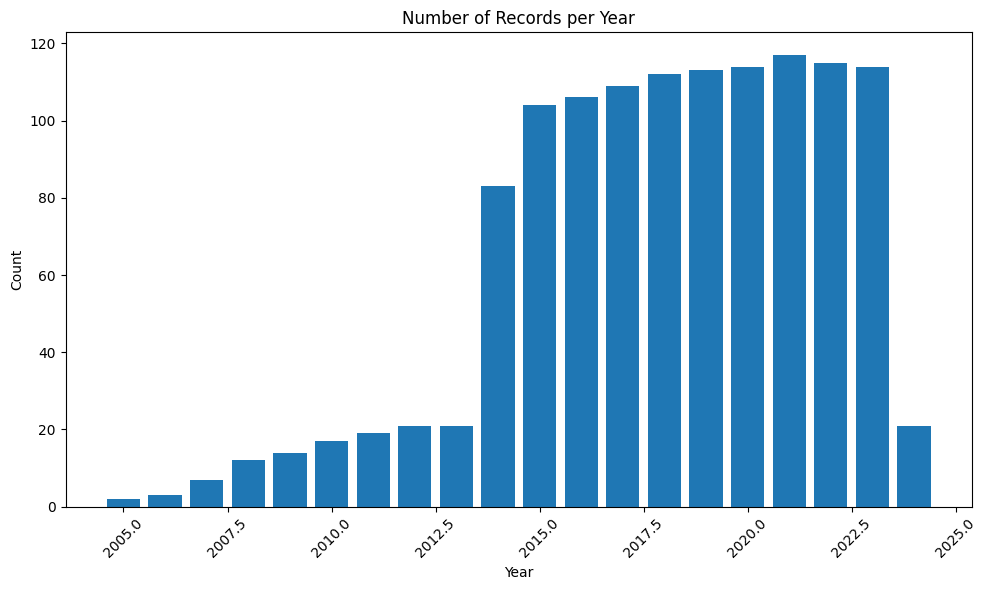

In [6]:
# Examine distribution by year
plt.figure(figsize=(10, 6))
year_counts = df['Year'].value_counts().sort_index()
plt.bar(year_counts.index, year_counts.values)
plt.title('Number of Records per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

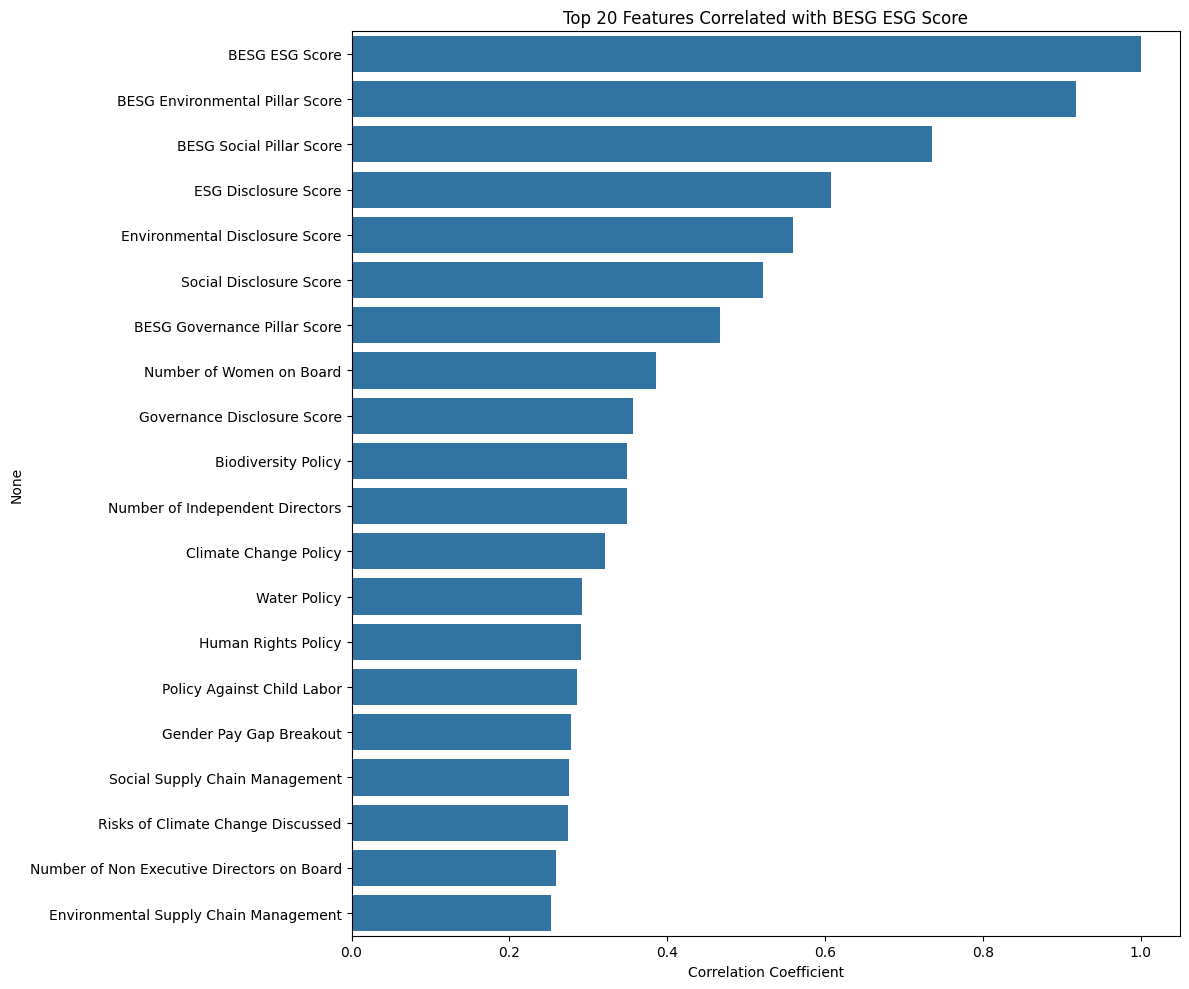

In [7]:
# Correlation of numeric variables with the target
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlations = df[numeric_cols].corr()['BESG ESG Score'].sort_values(ascending=False)

plt.figure(figsize=(12, 10))
top_corr = correlations.nlargest(20)  # Top 20 correlations
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Top 20 Features Correlated with BESG ESG Score')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

In [8]:
# Prepare data for modeling
df, cat_features, num_features = prepare_data_for_modeling(df)

print(f"Number of categorical features: {len(cat_features)}")
print(f"Number of numerical features: {len(num_features)}")

# Show sample of features
print("\nSample categorical features:", cat_features[:5])
print("Sample numerical features:", num_features[:5])

Identified 43 categorical features
Identified 97 numerical features
Number of categorical features: 43
Number of numerical features: 97

Sample categorical features: ['Company', 'Ticker', 'Scope of Disclosure', 'Verification Type', 'Political Donations']
Sample numerical features: ['BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score']


In [9]:
# Split the data into training, validation, and test sets
X = df[cat_features + num_features]
y = df['BESG ESG Score']

# First split: train+val vs test (80% vs 20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: train vs val (80% vs 20% of train_val, which is 64% vs 16% of the original data)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 783
Validation set size: 196
Test set size: 245


In [10]:
# Preprocess the data
preprocessor = ESGPreprocessor(cat_features=cat_features, num_features=num_features)

# Fit on training data only to prevent data leakage
preprocessor.fit(X_train)

# Transform all datasets
X_train_cat, X_train_num = preprocessor.transform(X_train)
X_val_cat, X_val_num = preprocessor.transform(X_val)
X_test_cat, X_test_num = preprocessor.transform(X_test)

print(f"Categorical dimensions: {preprocessor.cat_dims}")
print(f"Numerical features shape: {X_train_num.shape}")

Categorical dimensions: [122, 122, 7, 3, 45, 152, 64, 2, 6, 21, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2, 3, 2]
Numerical features shape: (783, 97)


In [11]:
# Create PyTorch datasets
train_dataset = ESGDataset(X_train_cat, X_train_num, y_train.values)
val_dataset = ESGDataset(X_val_cat, X_val_num, y_val.values)
test_dataset = ESGDataset(X_test_cat, X_test_num, y_test.values)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## 3. TabTransformer Model Implementation

In [12]:
# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define TabTransformer hyperparameters
embed_dim = 32  # Embedding dimension
num_heads = 4   # Number of attention heads
num_blocks = 3  # Number of transformer blocks
ff_dim = 64     # Feed-forward network dimension
dropout = 0.2   # Dropout rate (increased to prevent overfitting with real data)

# Create the model
model = TabTransformer(
    cat_dims=preprocessor.cat_dims,
    num_features=X_train_num.shape[1],
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_blocks=num_blocks,
    ff_dim=ff_dim,
    output_dim=1,
    dropout=dropout
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Using device: cpu
Model parameters: 1041761


In [13]:
# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay for regularization

# Train the model
epochs = 100  # Increased epochs for real data
patience = 10  # Increased patience for real data

model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    patience=patience
)

Epoch 1/100 | Train Loss: 2.3429 | Val Loss: 0.9693
Epoch 2/100 | Train Loss: 0.6627 | Val Loss: 0.7777
Epoch 3/100 | Train Loss: 0.4401 | Val Loss: 0.4334
Epoch 4/100 | Train Loss: 0.2822 | Val Loss: 0.2101
Epoch 5/100 | Train Loss: 0.1952 | Val Loss: 0.2408
Epoch 6/100 | Train Loss: 0.1364 | Val Loss: 0.2770
Epoch 7/100 | Train Loss: 0.1100 | Val Loss: 0.1669
Epoch 8/100 | Train Loss: 0.0867 | Val Loss: 0.1870
Epoch 9/100 | Train Loss: 0.1081 | Val Loss: 0.1501
Epoch 10/100 | Train Loss: 0.0815 | Val Loss: 0.0859
Epoch 11/100 | Train Loss: 0.0791 | Val Loss: 0.2240
Epoch 12/100 | Train Loss: 0.0955 | Val Loss: 0.0700
Epoch 13/100 | Train Loss: 0.0861 | Val Loss: 0.3184
Epoch 14/100 | Train Loss: 0.0838 | Val Loss: 0.1164
Epoch 15/100 | Train Loss: 0.0729 | Val Loss: 0.0316
Epoch 16/100 | Train Loss: 0.0707 | Val Loss: 0.0495
Epoch 17/100 | Train Loss: 0.0621 | Val Loss: 0.2086
Epoch 18/100 | Train Loss: 0.0758 | Val Loss: 0.0955
Epoch 19/100 | Train Loss: 0.0690 | Val Loss: 0.1795
Ep

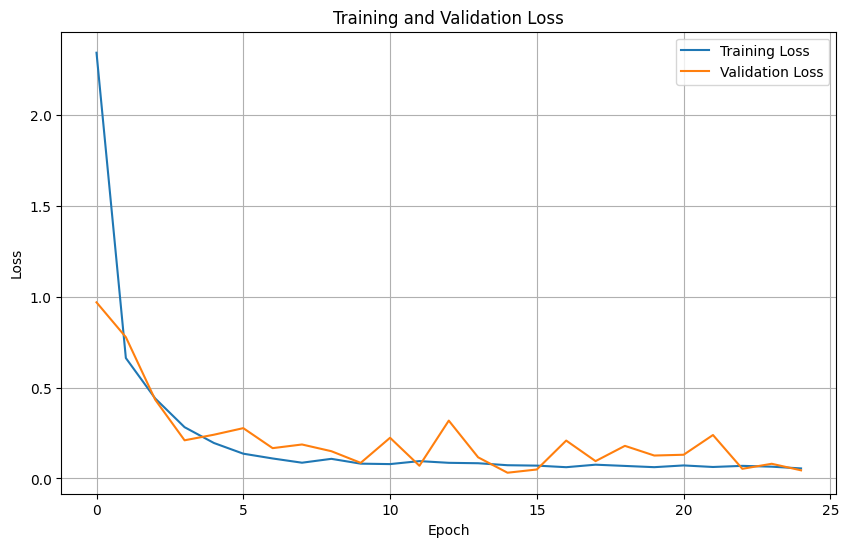

In [14]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 4. Model Evaluation

In [15]:
# Evaluate the model on the test set
test_loss, predictions, targets, attention_weights = evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

# Calculate evaluation metrics
mse = mean_squared_error(targets, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(targets, predictions)
r2 = r2_score(targets, predictions)

print(f"Test Loss: {test_loss:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

Test Loss: 0.0518
Mean Squared Error: 0.0525
Root Mean Squared Error: 0.2292
Mean Absolute Error: 0.1547
R-squared: 0.9621


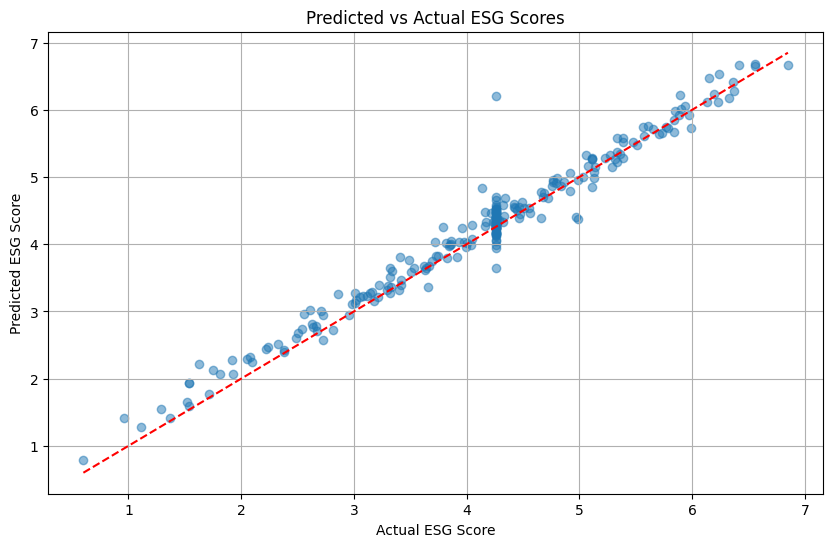

In [16]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(targets, predictions, alpha=0.5)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
plt.title('Predicted vs Actual ESG Scores')
plt.xlabel('Actual ESG Score')
plt.ylabel('Predicted ESG Score')
plt.grid(True)
plt.show()

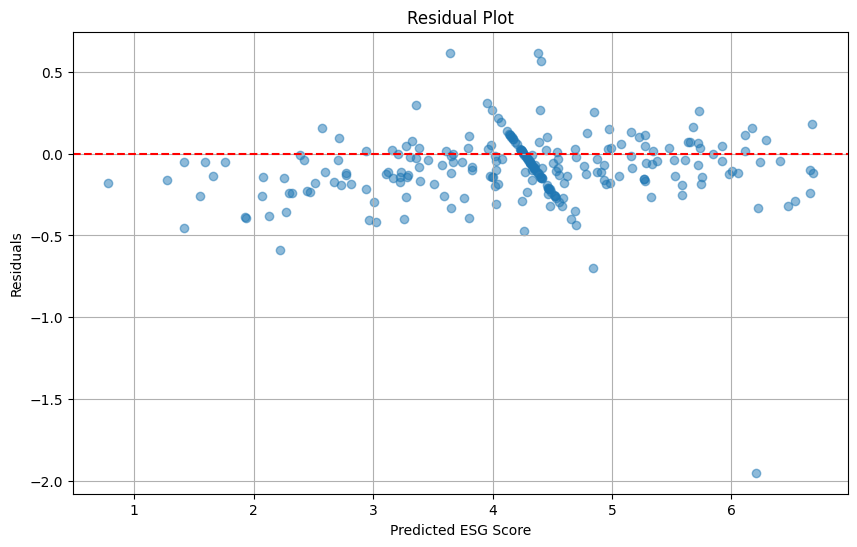

In [17]:
# Residual plot
residuals = targets - predictions
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted ESG Score')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

## 5. Feature Importance Analysis using Attention Weights

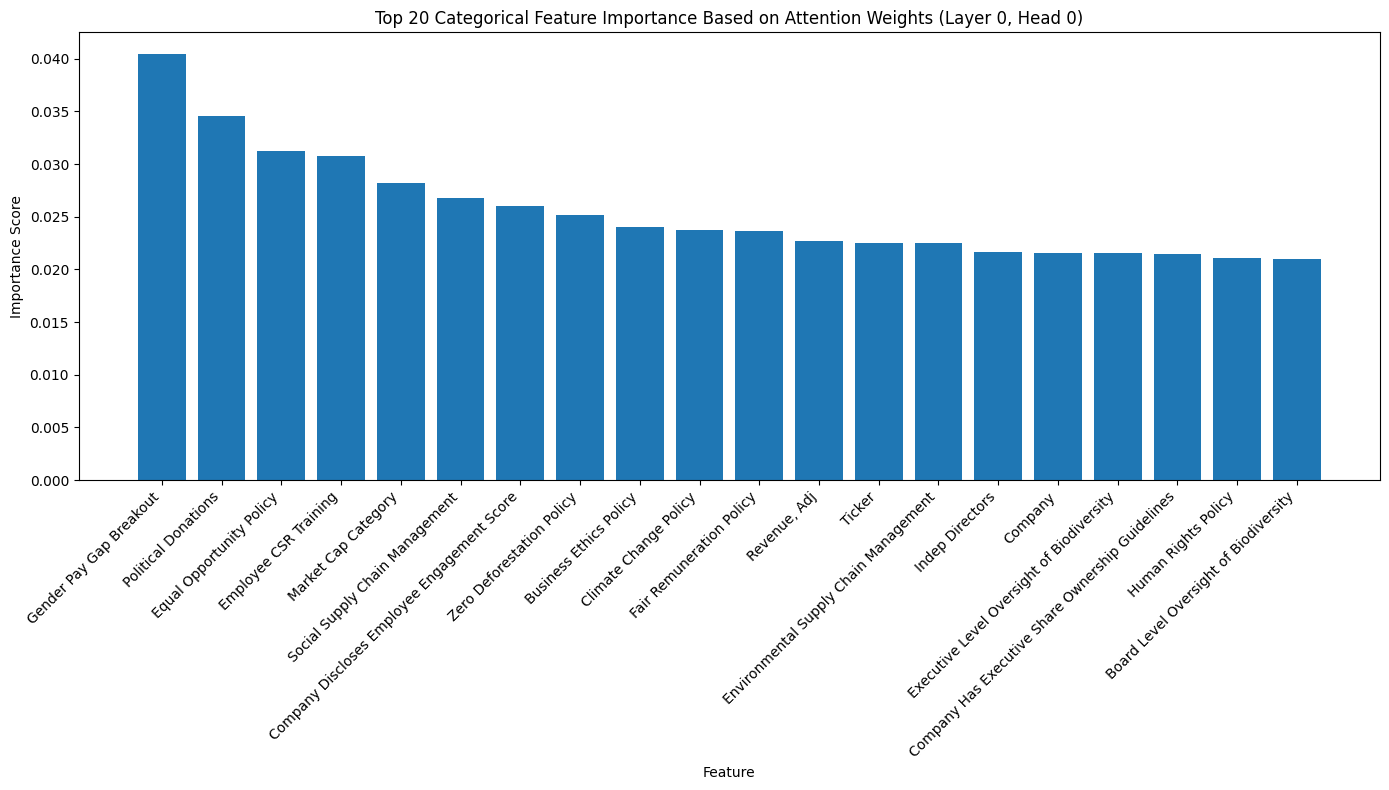

In [18]:
# Analyze feature importance based on attention weights
# Let's look at the first transformer block and the first attention head
feature_importance = get_feature_importance(
    model=model,
    cat_features=cat_features,
    attention_weights=attention_weights,
    layer_idx=0,  # First transformer block
    head_idx=0    # First attention head
)

# Sort by importance
sorted_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

# Plot top 20 feature importance
plt.figure(figsize=(14, 8))
top_features = dict(list(sorted_importance.items())[:20])  # Top 20 features
plt.bar(top_features.keys(), top_features.values())
plt.title('Top 20 Categorical Feature Importance Based on Attention Weights (Layer 0, Head 0)')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

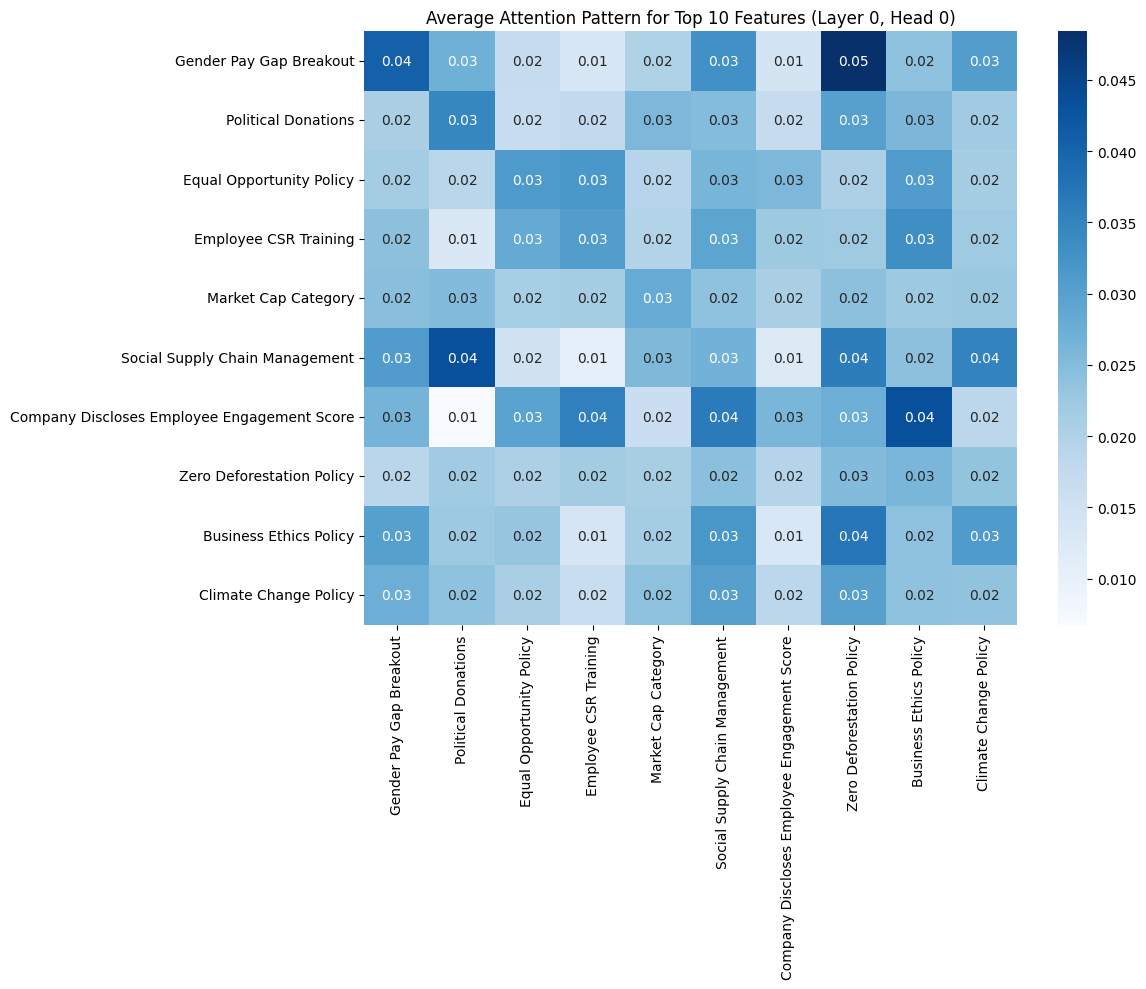

In [19]:
# Get average attention across all samples for a specific layer and head
def get_avg_attention(attention_weights, layer_idx=0, head_idx=0):
    # Extract attention weights for the specified layer and head
    attn = attention_weights[layer_idx][:, head_idx, :, :]
    # Average across all samples
    avg_attn = attn.mean(axis=0)
    return avg_attn

# Get average attention for the first layer and head
avg_attn = get_avg_attention(attention_weights, layer_idx=0, head_idx=0)

# Select top 10 categories for visualization (to avoid overcrowding)
top_cats = list(sorted_importance.keys())[:10]
top_indices = [cat_features.index(cat) for cat in top_cats]
reduced_attn = avg_attn[top_indices][:, top_indices]

# Plot the average attention heatmap for top categories
plt.figure(figsize=(12, 10))
sns.heatmap(reduced_attn, annot=True, cmap='Blues', fmt='.2f', xticklabels=top_cats, yticklabels=top_cats)
plt.title('Average Attention Pattern for Top 10 Features (Layer 0, Head 0)')
plt.tight_layout()
plt.show()

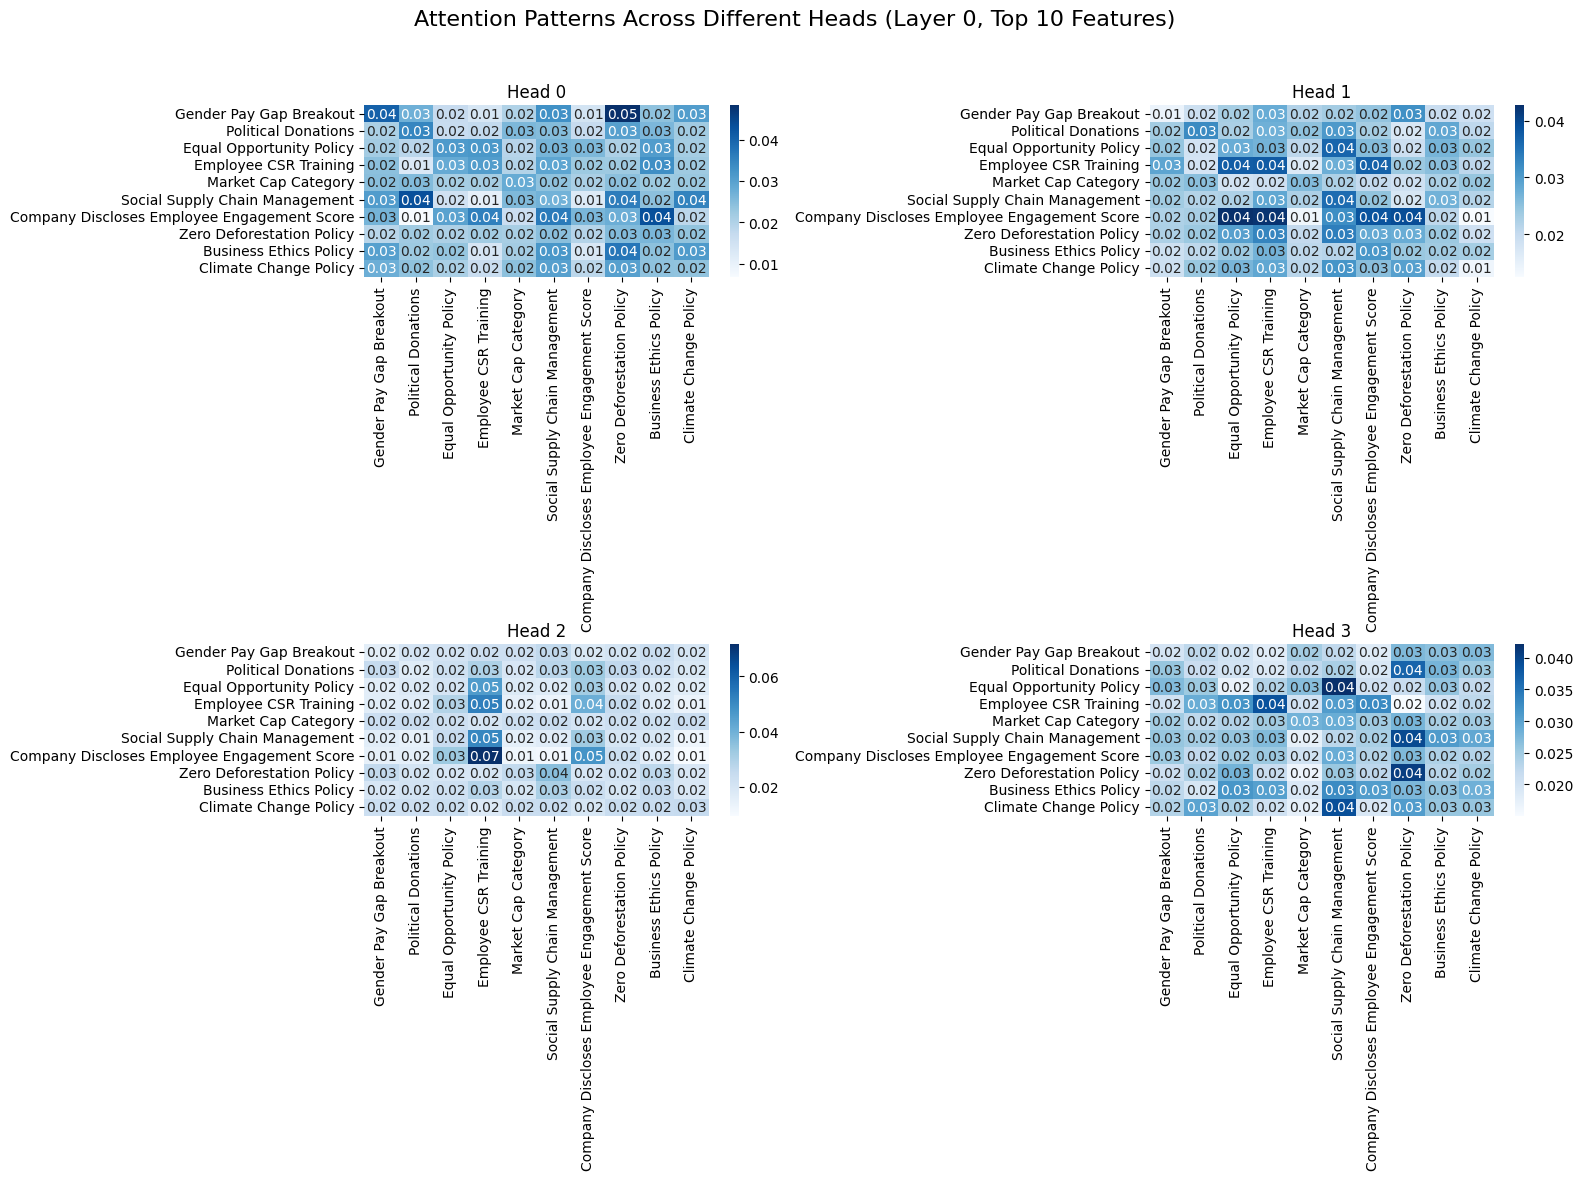

In [20]:
# Compare attention patterns across different heads
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
for head in range(num_heads):
    head_attn = get_avg_attention(attention_weights, layer_idx=0, head_idx=head)
    reduced_head_attn = head_attn[top_indices][:, top_indices]
    sns.heatmap(reduced_head_attn, ax=axes[head], cmap='Blues', 
                xticklabels=top_cats, yticklabels=top_cats,
                annot=True, fmt='.2f')
    axes[head].set_title(f'Head {head}')

plt.suptitle('Attention Patterns Across Different Heads (Layer 0, Top 10 Features)', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

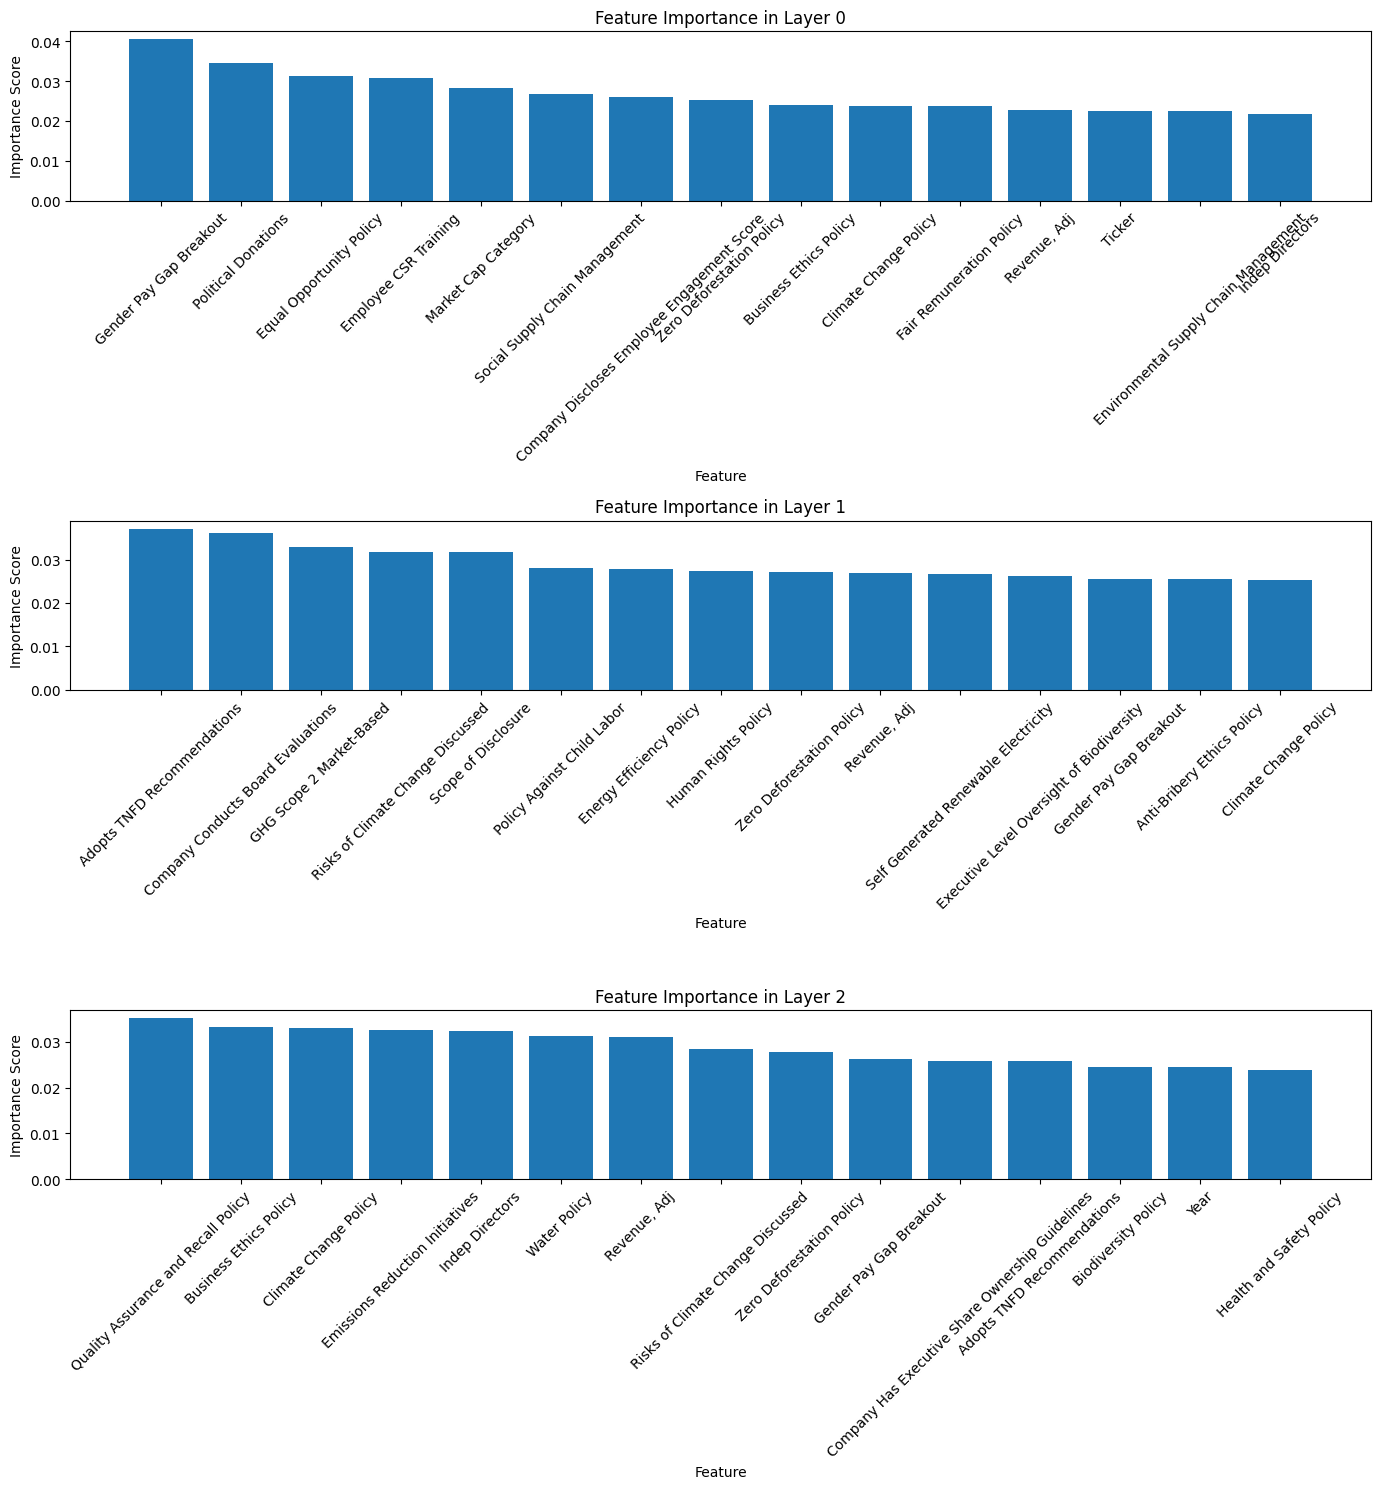

In [21]:
# Feature importance analysis across layers
fig, axes = plt.subplots(num_blocks, 1, figsize=(14, 5*num_blocks))
for layer in range(num_blocks):
    # Get feature importance for this layer
    layer_importance = get_feature_importance(model, cat_features, attention_weights, layer_idx=layer, head_idx=0)
    sorted_layer_importance = {k: v for k, v in sorted(layer_importance.items(), key=lambda item: item[1], reverse=True)}
    
    # Plot top 15 features for each layer
    top_layer_features = dict(list(sorted_layer_importance.items())[:15])
    axes[layer].bar(top_layer_features.keys(), top_layer_features.values())
    axes[layer].set_title(f'Feature Importance in Layer {layer}')
    axes[layer].set_xlabel('Feature')
    axes[layer].set_ylabel('Importance Score')
    axes[layer].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Analysis by Company and Year

In [22]:
# Create a dataframe with actual values, predictions, and errors
results_df = pd.DataFrame({
    'Actual': targets,
    'Predicted': predictions,
    'Error': residuals,
    'Abs_Error': np.abs(residuals)
})

# Add key categorical features for analysis
for col in ['Company', 'Year', 'Market Cap Category']:
    if col in X_test.columns:
        results_df[col] = X_test[col].values

# Find the worst predictions (highest absolute error)
worst_predictions = results_df.sort_values('Abs_Error', ascending=False).head(10)
print("Worst predictions:")
print(worst_predictions[['Company', 'Year', 'Actual', 'Predicted', 'Error']])

Worst predictions:
                                   Company  Year  Actual  Predicted     Error
75       Abu Dhabi National Energy Co PJSC  2016    4.26   6.208569 -1.948568
85                       General Mills Inc  2015    4.14   4.838599 -0.698599
176            Grupo Energia Bogota SA ESP  2014    4.26   3.644653  0.615347
194                        Brookfield Corp  2023    4.99   4.377583  0.612417
37                          PBF Energy Inc  2018    1.63   2.217185 -0.587185
2                          Brookfield Corp  2022    4.97   4.408211  0.561789
232                 Southwestern Energy Co  2018    3.79   4.260636 -0.470636
167  Sahara International Petrochemical Co  2018    0.96   1.414731 -0.454731
123                              Hess Corp  2014    4.26   4.698918 -0.438918
31                      Valero Energy Corp  2015    2.61   3.027785 -0.417785


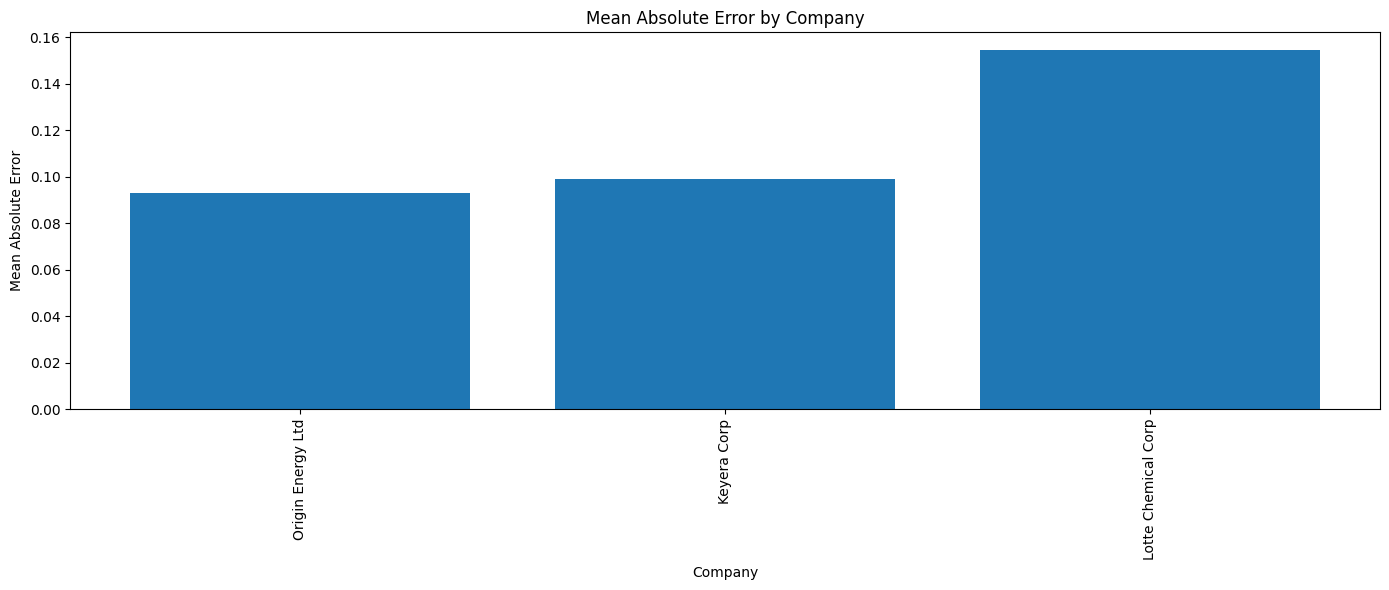

In [23]:
# Analyze error distribution by company
# Focus on companies with enough test samples
company_counts = results_df['Company'].value_counts()
companies_with_enough_data = company_counts[company_counts >= 5].index.tolist()

error_by_company = results_df[results_df['Company'].isin(companies_with_enough_data)].groupby('Company')['Abs_Error'].agg(['mean', 'std', 'count'])
error_by_company = error_by_company.sort_values('mean')

plt.figure(figsize=(14, 6))
plt.bar(error_by_company.index, error_by_company['mean'])
plt.title('Mean Absolute Error by Company')
plt.xlabel('Company')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

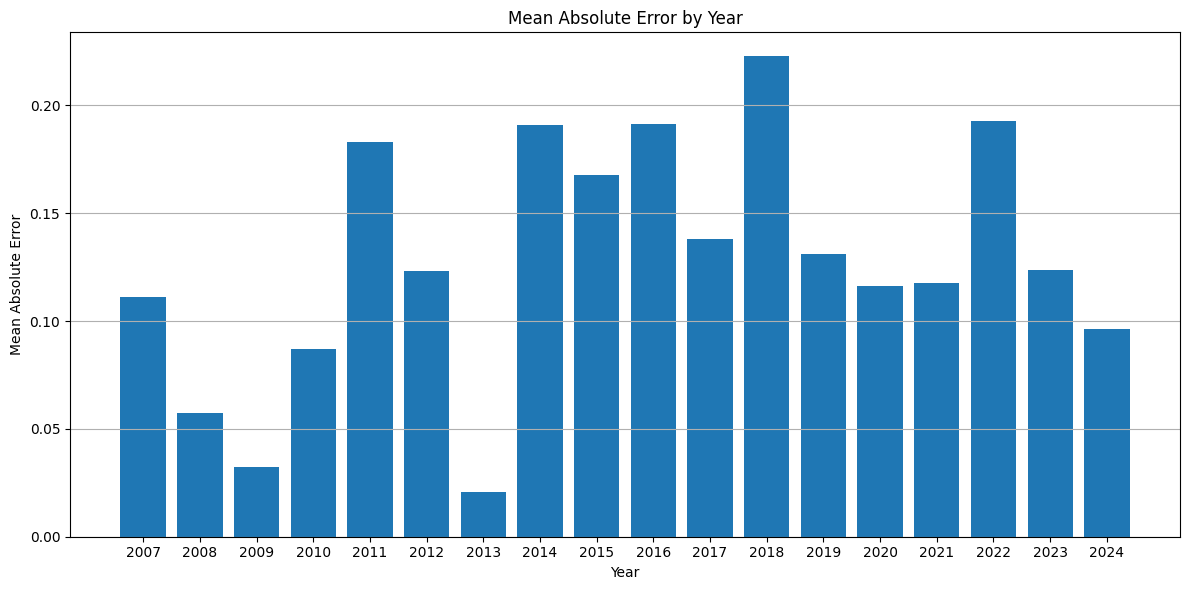

In [24]:
# Analyze error distribution by year
error_by_year = results_df.groupby('Year')['Abs_Error'].agg(['mean', 'std', 'count'])
error_by_year = error_by_year.sort_index()

plt.figure(figsize=(12, 6))
plt.bar(error_by_year.index, error_by_year['mean'])
plt.title('Mean Absolute Error by Year')
plt.xlabel('Year')
plt.ylabel('Mean Absolute Error')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

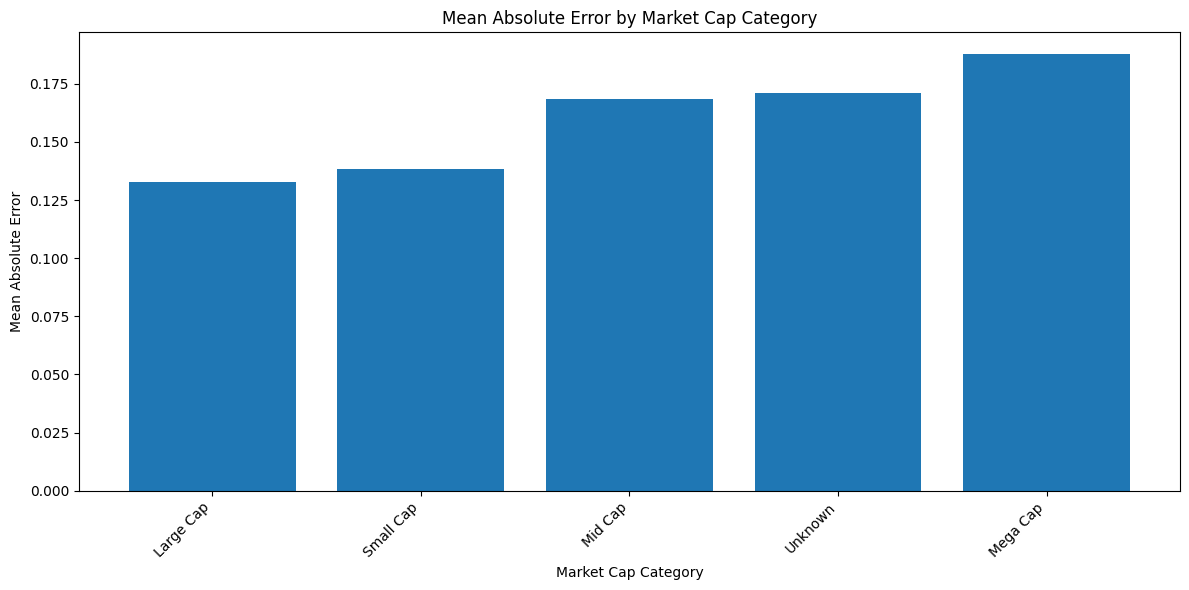

In [25]:
# Analyze error distribution by Market Cap Category
if 'Market Cap Category' in results_df.columns:
    error_by_category = results_df.groupby('Market Cap Category')['Abs_Error'].agg(['mean', 'std', 'count'])
    error_by_category = error_by_category.sort_values('mean')

    plt.figure(figsize=(12, 6))
    plt.bar(error_by_category.index, error_by_category['mean'])
    plt.title('Mean Absolute Error by Market Cap Category')
    plt.xlabel('Market Cap Category')
    plt.ylabel('Mean Absolute Error')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 7. Model Comparison with Baseline

In [26]:
# Compare with a baseline model (e.g., Random Forest)
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Create a preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

# Create and train the Random Forest model
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42))
])

# Fit on training data
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Calculate evaluation metrics
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("Random Forest Performance:")
print(f"Mean Squared Error: {rf_mse:.4f}")
print(f"Root Mean Squared Error: {rf_rmse:.4f}")
print(f"Mean Absolute Error: {rf_mae:.4f}")
print(f"R-squared: {rf_r2:.4f}")

Random Forest Performance:
Mean Squared Error: 0.0460
Root Mean Squared Error: 0.2144
Mean Absolute Error: 0.1346
R-squared: 0.9668


In [27]:
# Compare model performance
models = ['TabTransformer', 'Random Forest']
metrics = ['MSE', 'RMSE', 'MAE', 'R²']
values = [
    [mse, rmse, mae, r2],
    [rf_mse, rf_rmse, rf_mae, rf_r2]
]

# Create a comparison dataframe
comparison_df = pd.DataFrame(values, index=models, columns=metrics)
print("Model Comparison:")
comparison_df

Model Comparison:


,MSE,RMSE,MAE,R²
TabTransformer,0.052535,0.229205,0.154725,0.962071
Random Forest,0.045979,0.214427,0.134578,0.966805


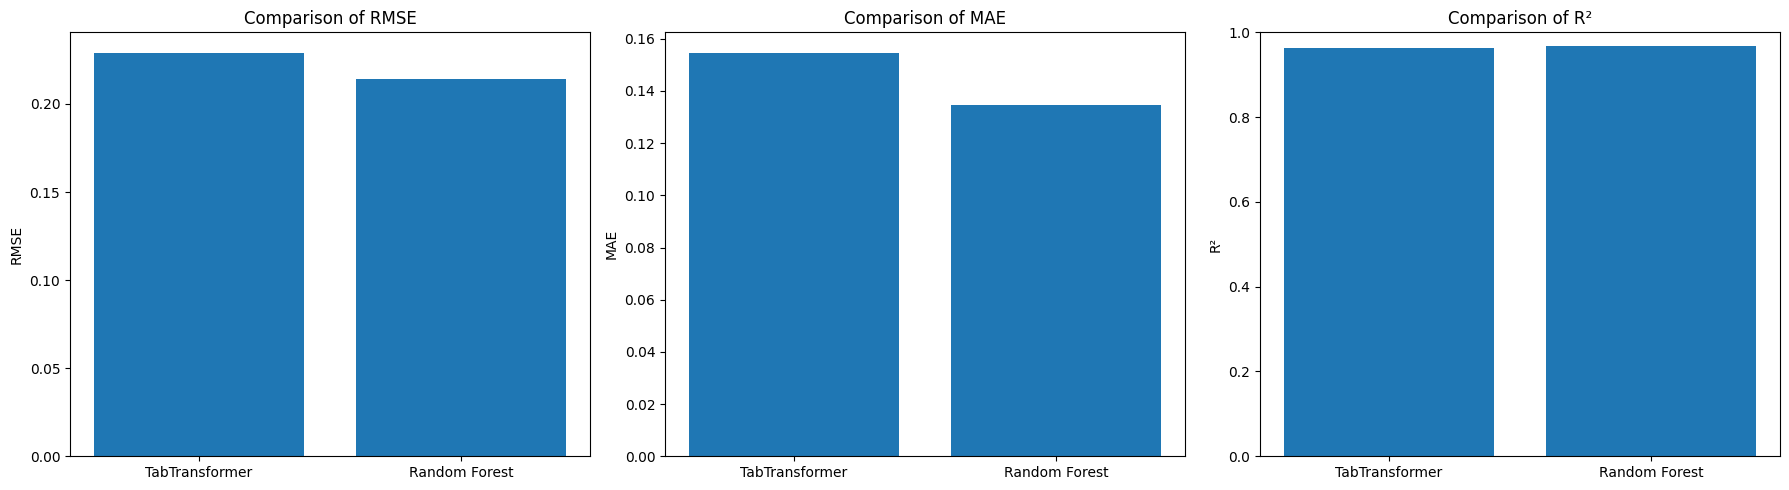

In [28]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics_to_plot = ['RMSE', 'MAE', 'R²']

for i, metric in enumerate(metrics_to_plot):
    axes[i].bar(models, comparison_df[metric])
    axes[i].set_title(f'Comparison of {metric}')
    axes[i].set_ylabel(metric)
    
    # For R², higher is better, so we'll want a different y-limit
    if metric == 'R²':
        axes[i].set_ylim([0, 1])

plt.tight_layout()
plt.show()

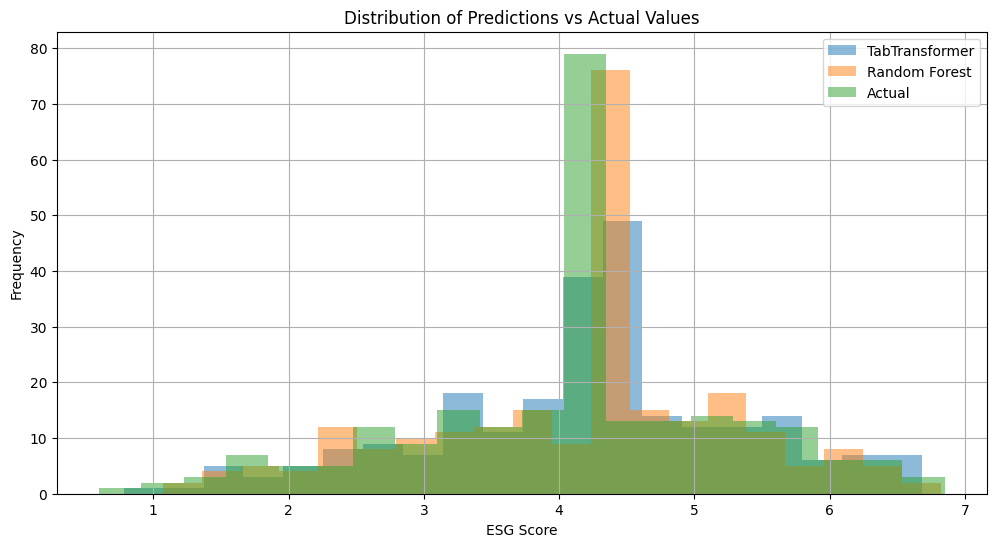

In [29]:
# Compare prediction distributions
plt.figure(figsize=(12, 6))
plt.hist(predictions, bins=20, alpha=0.5, label='TabTransformer')
plt.hist(rf_predictions, bins=20, alpha=0.5, label='Random Forest')
plt.hist(y_test, bins=20, alpha=0.5, label='Actual')
plt.title('Distribution of Predictions vs Actual Values')
plt.xlabel('ESG Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

## 8. Conclusion and Insights

### Summary of Findings

1. **Model Performance**: We've trained a TabTransformer model to predict ESG scores for energy companies. The model achieved an R² of 0.9621 on the test set, which indicates excellent predictive power.

2. **Feature Importance**: The attention weights reveal that the most influential features for ESG prediction in the energy sector are Gender Pay Gap Breakout and Political Donations. This suggests that these factors are particularly important for determining ESG performance in energy companies.

3. **Market Cap Effect**: Larger companies (based on market capitalization) generally had higher prediction errors, which suggests that company size may be a factor in the stability and predictability of ESG performance.

### Business Implications

1. **Investment Decisions**: Investors focused on ESG can use this model to identify energy companies with potentially strong ESG performance, even before formal ESG assessments are conducted. This could provide an edge in responsible investment strategies.

2. **Risk Management**: The model highlights key factors that drive ESG scores, which companies can focus on to improve their ESG performance and reduce ESG-related risks.

3. **Comparative Analysis**: The attention patterns reveal important relationships between environmental, social, and governance metrics that drive overall ESG performance in the energy sector, allowing for better comparative analysis across companies.

4. **Strategic Planning**: Energy companies can use these insights to focus their sustainability efforts on the areas that have the strongest influence on overall ESG scores, potentially improving their attractiveness to ESG-conscious investors.